# Predicting the NBA MVP with Machine Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<img src="https://i0.wp.com/fumblenanet.com.br/wp-content/uploads/2021/04/mvp-trophy.jpg?fit=1200%2C630&ssl=1" width="650"/>

Notebook containing the code described in **[Medium](https://medium.com/@gabriel.pastorello/predicting-the-nba-mvp-with-machine-learning-c3e5b755f42e "Medium")**.

Complete code and databases in **[GitHub](https://github.com/GabrielPastorello/NBA-Modelo-MVP "GitHub")**.

# Index

**1. [Importing packages](#Importing-packages)**

**2. [Opening and processing the data](#Opening-and-processing-the-data)**

**3. [Modeling 2021-22](#Modeling-2021-22)**

**4. [Old seasons](#Old-seasons)**

**5. [Variable Analysis - SHAP](#Variable-Analysis---SHAP)**

## Importing packages

In [ ]:
!git clone https://github.com/GabrielPastorello/NBA-Modelo-MVP.git

Cloning into 'NBA-Modelo-MVP'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 114 (delta 6), reused 0 (delta 0), pack-reused 99 (from 1)
Receiving objects: 100% (114/114), 3.21 MiB | 5.98 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
!pip install shap
!pip install xgboost
!pip install knn

  Preparing metadata (setup.py) ... done
  Created wheel for knn: filename=KNN-1.0.0-py3-none-any.whl size=3112 sha256=f8be4854c124d3b09950c87330adea84d331ac519e842994bd7abf1012c07398
  Stored in directory: /root/.cache/pip/wheels/95/51/6d/f63346d97cc5736123d538506481bf9f6d4098c2550bc29345
Successfully built knn


In [ ]:
import pandas as pd
#from glmnet import GLMNRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Defining the seasons and models used
seasons = ['2021-22','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07']

modelos = ['KNN','SVM','Elastic Net','Random Forest','AdaBoost','Gradient Boosting','LGBM', 'XGBoost']

# Path to local folder
path_data = r'/content/NBA-Modelo-MVP/Modelo MVP'

sep = r'/'

## Opening and processing the data

In [ ]:
def get_data(seasons):

    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    avancados = pd.DataFrame()
    standings = pd.DataFrame()

    for season in seasons:
        pergame = pd.read_csv(path_data+sep+'Dados'+sep+season+' Por Jogo.csv',
                               sep=',', decimal='.')

        total = pd.read_csv(path_data+sep+'Dados'+sep+season+' Total.csv',
                            sep=',', decimal='.')

        avancado = pd.read_csv(path_data+sep+'Dados'+sep+season+' Avançados.csv',
                               sep=',', decimal='.')

        standing = pd.read_csv(path_data+sep+'Dados'+sep+season+' Standings.csv',
                               sep=',', decimal='.')


        pergame['Season'] = season
        total['Season'] = season
        avancado['Season'] = season
        standing['Season'] = season

        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        avancados = pd.concat([avancados,avancado], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)

    return per_game, totals, avancados, standings

In [ ]:
def treat_data(per_game, totals, avancados, standings, seasons):

    # Removing duplicate/empty columns
    per_game = per_game.drop(['Rk','Pos'], axis=1)
    totals = totals.drop(['Rk','Pos','Age','G','GS'], axis=1)
    avancados = avancados.drop(['Rk','Pos','Age','G','MP','Unnamed: 24','Unnamed: 19'], axis=1)

    cols = ['Player','Season','Pos','Age','Tm','G','GS']

    # Identifying the variables
    for coluna in per_game.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_PERGAME'
            per_game = per_game.rename(columns={coluna:nova_coluna})
    for coluna in totals.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_TOTAL'
            totals = totals.rename(columns={coluna:nova_coluna})
    for coluna in avancados.columns:
        if coluna not in cols:
            nova_coluna = coluna+'_AVANCADO'
            avancados = avancados.rename(columns={coluna:nova_coluna})

    # Merging the bases
    data = per_game.merge(avancados, on=['Player','Season','Tm'], how='left', validate='1:1')
    data = data.merge(totals, on=['Player','Season','Tm'], how='left', validate='1:1')

    dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
                 'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
                 'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
                 'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
                 'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
                 'Atlanta Hawks':'ATL','New York Knicks':'NYK',
                 'Miami Heat':'MIA','Golden State Warriors':'GSW',
                 'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
                 'Washington Wizards':'WAS','Indiana Pacers':'IND',
                 'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
                 'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
                 'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
                 'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
                 'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
                 'Orlando Magic':'ORL','Detroit Pistons':'DET',
                 'Houston Rockets':'HOU','New Jersey Nets':'NJN',
                 'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA'}

    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    wins = (standings['Record'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Record'].str.split('-',expand=True)[0]).astype(int)+(standings['Record'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games

    data = data.merge(standings, on=['Tm','Season'], how='left', validate='m:1')

    data['Player'] = data['Player'].str.replace('*','')

    mvps = pd.read_csv(path_data+sep+'Dados'+sep+'MVPs.csv',sep=',', decimal='.')
    data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0)

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]

    # Removing duplicate lines from traded players
    dataf = pd.DataFrame()
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        dataf = pd.concat([dataf,data_season], ignore_index=True)

    # Filtering the data
    dataf = dataf[((dataf['G']>48)&(dataf['PTS_PERGAME']>13.5)&(dataf['MP_PERGAME']>30)
                 &(dataf['Seed']<=16)&(dataf['AST_PERGAME']>1)&(dataf['TRB_PERGAME']>3)
                 &(dataf['Tm']!='TOT')&(dataf['FG%_PERGAME']>0.37)&(dataf['FGA_PERGAME']>10)
                 &(dataf['PER_AVANCADO']>18)) | (dataf['MVP Votes Share']>0)].reset_index(drop=True)

    dataf = dataf.drop(['Tm','Team','Record'], axis=1)

    return dataf

In [ ]:
#player_data = pd.read_csv(path_data+sep+'Dados'+sep+'player_data.csv',sep=',', decimal='.')
player_data = pd.read_csv("/content/drive/MyDrive/Datasets_MVP/player_data.csv")
player_dataf = player_data.drop(['year_start', 'year_end', 'position', 'college', 'birth_date'], axis=1)
inches = player_dataf['height']
player_dataf[['feet', 'inches']] = player_dataf['height'].str.split('-', expand=True)

player_dataf = player_dataf[~player_dataf['feet'].isnull()]
player_dataf = player_dataf[~player_dataf['inches'].isnull()]
player_dataf['feet'] = player_dataf['feet'].astype('int')
player_dataf['inches'] = player_dataf['inches'].astype('int')
player_dataf['height (in)'] = player_dataf['feet']*12 + player_dataf['inches']
player_dataf = player_dataf.drop(['feet', 'inches'], axis=1)

print(player_dataf)
#print(player_dataf)

                     name height  weight  height (in)
0          Alaa Abdelnaby   6-10   240.0           82
1         Zaid Abdul-Aziz    6-9   235.0           81
2     Kareem Abdul-Jabbar    7-2   225.0           86
3      Mahmoud Abdul-Rauf    6-1   162.0           73
4       Tariq Abdul-Wahad    6-6   223.0           78
...                   ...    ...     ...          ...
4545           Ante Zizic   6-11   250.0           83
4546             Jim Zoet    7-1   240.0           85
4547            Bill Zopf    6-1   170.0           73
4548          Ivica Zubac    7-1   265.0           85
4549           Matt Zunic    6-3   195.0           75

[4549 rows x 4 columns]


In [ ]:
per_game, totals, avancados, standings = get_data(seasons)

In [ ]:
data = treat_data(per_game, totals, avancados, standings, seasons)

In [ ]:
data

,Player,Age,G,GS,MP_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,3PA_PERGAME,...,AST_TOTAL,STL_TOTAL,BLK_TOTAL,TOV_TOTAL,PF_TOTAL,PTS_TOTAL,Seed,PCT,MVP Rank,MVP Votes Share
0,Bam Adebayo,24,56,56,32.6,7.3,13.0,0.557,0.0,0.1,...,190,80,44,148,171,1068,4.0,0.646341,0,0.000
1,Giannis Antetokounmpo,27,67,67,32.9,10.3,18.6,0.553,1.1,3.6,...,388,72,91,219,212,2002,7.0,0.621951,3,0.595
2,Devin Booker,25,68,68,34.5,9.7,20.9,0.466,2.7,7.0,...,329,77,26,162,180,1822,1.0,0.780488,4,0.216
3,Jaylen Brown,25,66,66,33.6,8.7,18.4,0.473,2.5,7.0,...,231,70,18,178,163,1559,6.0,0.621951,0,0.000
4,Jimmy Butler,32,57,57,33.9,7.0,14.5,0.480,0.5,2.0,...,312,94,27,121,88,1219,4.0,0.646341,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,Tony Parker,24,77,77,32.5,7.4,14.2,0.520,0.2,0.5,...,420,82,6,191,137,1429,3.0,0.707317,15T,0.001
404,Chris Paul,21,64,64,36.8,6.0,13.6,0.437,0.8,2.2,...,569,118,3,161,154,1104,0.0,0.000000,0,0.000
405,Amar'e Stoudemire,24,82,78,32.8,7.4,12.9,0.575,0.0,0.0,...,84,78,110,232,295,1671,2.0,0.743902,14,0.002
406,Dwyane Wade,25,51,50,37.9,9.3,18.9,0.491,0.4,1.5,...,384,107,62,216,117,1397,11.0,0.536585,12T,0.002


In [ ]:
data.columns # Variables

Index(['Player', 'Age', 'G', 'GS', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'eFG%_PERGAME', 'FT_PERGAME',
       'FTA_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME', 'DRB_PERGAME',
       'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME', 'Season', 'PER_AVANCADO',
       'TS%_AVANCADO', '3PAr_AVANCADO', 'FTr_AVANCADO', 'ORB%_AVANCADO',
       'DRB%_AVANCADO', 'TRB%_AVANCADO', 'AST%_AVANCADO', 'STL%_AVANCADO',
       'BLK%_AVANCADO', 'TOV%_AVANCADO', 'USG%_AVANCADO', 'OWS_AVANCADO',
       'DWS_AVANCADO', 'WS_AVANCADO', 'WS/48_AVANCADO', 'OBPM_AVANCADO',
       'DBPM_AVANCADO', 'BPM_AVANCADO', 'VORP_AVANCADO', 'MP_TOTAL',
       'FG_TOTAL', 'FGA_TOTAL', 'FG%_TOTAL', '3P_TOTAL', '3PA_TOTAL',
       '3P%_TOTAL', '2P_TOTAL', '2PA_TOTAL', '2P%_TOTAL', 'eFG%_TOTAL',
       'FT_TOTAL', 'FTA_TOTAL', 'FT%_TOTAL', 'ORB_TOTAL', 

In [ ]:
data['Season'].value_counts() # Number of players in the data per season

,count
Season,
2016-17,29
2007-08,29
2006-07,29
2011-12,29
2010-11,28
2020-21,28
2013-14,27
2009-10,27
2021-22,25


In [ ]:
player_dataf = player_dataf.rename(columns={"name": "Player"})
stats = data
data.merge(player_dataf)

,Player,Age,G,GS,MP_PERGAME,FG_PERGAME,FGA_PERGAME,FG%_PERGAME,3P_PERGAME,3PA_PERGAME,...,TOV_TOTAL,PF_TOTAL,PTS_TOTAL,Seed,PCT,MVP Rank,MVP Votes Share,height,weight,height (in)
0,Bam Adebayo,24,56,56,32.6,7.3,13.0,0.557,0.0,0.1,...,148,171,1068,4.0,0.646341,0,0.000,6-10,243.0,82
1,Giannis Antetokounmpo,27,67,67,32.9,10.3,18.6,0.553,1.1,3.6,...,219,212,2002,7.0,0.621951,3,0.595,6-11,222.0,83
2,Devin Booker,25,68,68,34.5,9.7,20.9,0.466,2.7,7.0,...,162,180,1822,1.0,0.780488,4,0.216,6-6,206.0,78
3,Jaylen Brown,25,66,66,33.6,8.7,18.4,0.473,2.5,7.0,...,178,163,1559,6.0,0.621951,0,0.000,6-7,225.0,79
4,Jimmy Butler,32,57,57,33.9,7.0,14.5,0.480,0.5,2.0,...,121,88,1219,4.0,0.646341,0,0.000,6-8,236.0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,Tony Parker,24,77,77,32.5,7.4,14.2,0.520,0.2,0.5,...,191,137,1429,3.0,0.707317,15T,0.001,6-2,185.0,74
385,Chris Paul,21,64,64,36.8,6.0,13.6,0.437,0.8,2.2,...,161,154,1104,0.0,0.000000,0,0.000,6-0,175.0,72
386,Amar'e Stoudemire,24,82,78,32.8,7.4,12.9,0.575,0.0,0.0,...,232,295,1671,2.0,0.743902,14,0.002,6-10,245.0,82
387,Dwyane Wade,25,51,50,37.9,9.3,18.9,0.491,0.4,1.5,...,216,117,1397,11.0,0.536585,12T,0.002,6-4,220.0,76


## Modeling 2021-22

In [ ]:
"""
i = 0;

for item in data['Age']:
  player_dataf.insert(1, "Age", item, index=[i, i+1])
  i += 1
"""

player_dataf.insert(loc = 0, column = "Age", value = data['Age'])
player_dataf.insert(loc = 1, column = "Season", value = data['Season'])
player_dataf.insert(loc = 2, column = "MVP Votes Share", value = data['MVP Votes Share'])
player_dataf.insert(loc = 3, column = "MVP Rank", value = data['MVP Rank'])
player_dataf = player_dataf.drop(['height'], axis = 1)
player_dataf = player_dataf.rename(columns={"height (in)": "height"})
stats = stats.drop(['Age'], axis=1)
#stats
player_dataf
#data


,Age,Season,MVP Votes Share,MVP Rank,Player,weight,height
0,24.0,2021-22,0.000,0,Alaa Abdelnaby,240.0,82
1,27.0,2021-22,0.595,3,Zaid Abdul-Aziz,235.0,81
2,25.0,2021-22,0.216,4,Kareem Abdul-Jabbar,225.0,86
3,25.0,2021-22,0.000,0,Mahmoud Abdul-Rauf,162.0,73
4,32.0,2021-22,0.000,0,Tariq Abdul-Wahad,223.0,78
...,...,...,...,...,...,...,...
4545,NaN,NaN,NaN,NaN,Ante Zizic,250.0,83
4546,NaN,NaN,NaN,NaN,Jim Zoet,240.0,85
4547,NaN,NaN,NaN,NaN,Bill Zopf,170.0,73
4548,NaN,NaN,NaN,NaN,Ivica Zubac,265.0,85


In [ ]:
# Function for metrics
def func_metricas(y_test, y_pred, metricas, modelo, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²

    dict_met = {'Modelo': [modelo],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}

    metrica = pd.DataFrame(data=dict_met)
    metricas = pd.concat([metricas,metrica])

    return metricas

In [ ]:
def func_modelos(data, seasons, modelos, n_seasons_to_test):


    final_results = pd.DataFrame()
    metricas = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
        # Separating training and testing bases
        season_teste = season

        data_train = data[data['Season']!=season_teste]
        data_test = data[data['Season']==season_teste]

        y_train = data_train['MVP Votes Share']

        y_test = data_test['MVP Votes Share']

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for modelo in modelos:
          print(modelo)

          # Creating instance for each model

          if modelo=='SVM':
              param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                          'kernel': ['linear','rbf','poly'],
                          'gamma': ['scale','auto'],
                          'degree': [2,3,4],
                          'epsilon': [0.1,0.5,1]}
              svr_model = SVR()
              grid = GridSearchCV(svr_model, param_grid)
              grid.fit(scaled_X_train, y_train)
              model = SVR(**grid.best_params_)
              best_params.append(grid.best_params_)

          elif modelo=='KNN':
              param_grid = {'n_neighbors': (1,10, 1), 'leaf_size': (20,40,1),
                            'p': (1,2), 'weights': ('uniform', 'distance'),
                            'metric': ('minkowski', 'chebyshev')}
              knn_model = KNeighborsRegressor()
              grid = GridSearchCV(knn_model, param_grid)
              grid.fit(scaled_X_train, y_train)
              model = KNeighborsRegressor(**grid.best_params_)
              #model = grid_search_KNN.best_params_
              best_params.append(grid.best_params_)


          elif modelo=='Random Forest':
              param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                          'max_features': [2,3,4,5],
                          'bootstrap': [True,False],
                          'oob_score': [True]}
              rfc = RandomForestRegressor()
              grid = GridSearchCV(rfc, param_grid)
              grid.fit(scaled_X_train, y_train)
              model = RandomForestRegressor(**grid.best_params_)
              best_params.append(grid.best_params_)

          elif modelo=='AdaBoost':
              param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                          'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
              ada_model = AdaBoostRegressor()
              grid = GridSearchCV(ada_model, param_grid)
              grid.fit(scaled_X_train, y_train)
              model = AdaBoostRegressor(**grid.best_params_)
              best_params.append(grid.best_params_)

          elif modelo=='Gradient Boosting':
              param_grid = {'n_estimators': [10,20,30,40,50],
                          'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                          'max_depth': [3,4,5]}
              gb_model = GradientBoostingRegressor()
              grid = GridSearchCV(gb_model, param_grid)
              grid.fit(scaled_X_train, y_train)
              model = GradientBoostingRegressor(**grid.best_params_)
              best_params.append(grid.best_params_)

          model.fit(scaled_X_train, y_train)

          file = open(path_data + sep + "Modelos" + sep + modelo + ".dat", 'wb')
          pickle.dump(model, file)

          y_pred = model.predict(scaled_X_test)
          metricas = func_metricas(y_test, y_pred, metricas, modelo, season)

          apoio = initial_results.copy()
          apoio['Predicted MVP Share '+modelo] = pd.Series(y_pred).values

          results_sorted = apoio.sort_values(by='Predicted MVP Share '+modelo,
                                              ascending=False).reset_index(drop=True)
          results_sorted['MVP Rank '+modelo] = results_sorted.index+1

          results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
          break

        i = i + 1

    np.savetxt(path_data+sep+r'Modelos\params.csv', best_params, delimiter =', ', fmt ='% s')

    return final_results, metricas, best_params

In [ ]:
def media_metricas(metricas):
    # Averages of each of the models
    final_metricas = pd.DataFrame()
    for modelo in metricas['Modelo'].unique():
        metrica = metricas[metricas['Modelo']==modelo]
        rmse = round(metrica['RMSE'].mean(),3)
        r2 = round(metrica['R²'].mean(),3)

        dict_met = {'Modelo': [modelo],
                    'RMSE': [rmse],
                    'R²': [r2]}

        apoio = pd.DataFrame(data=dict_met)
        final_metricas = pd.concat([final_metricas,apoio], ignore_index=True)
    return final_metricas

In [ ]:
final_results, metricas, best_params = func_modelos(data, seasons, modelos, 1)
final_metricas = media_metricas(metricas)
final_metricas

KNN
SVM
Elastic Net
Random Forest
AdaBoost
Gradient Boosting
LGBM
XGBoost


,Modelo,RMSE,R²
0,KNN,0.113,0.775
1,SVM,0.087,0.867
2,Elastic Net,0.087,0.867
3,Random Forest,0.104,0.810
4,AdaBoost,0.116,0.762
5,Gradient Boosting,0.113,0.774
6,LGBM,0.115,0.766
7,XGBoost,0.112,0.778


In [ ]:
def create_rank(final_results, n_rank):
    rank_final = pd.DataFrame()

    for season in final_results['Season'].unique():
        temp = final_results[final_results['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MVP Votes Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MVP Rank Real'] = rank_real['Player']
        rank['MVP Share Real'] = rank_real['MVP Votes Share']
        for modelo in modelos:
            try:
                temp2 = temp.sort_values(by='Predicted MVP Share '+modelo, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MVP Rank '+modelo] = temp2['Player']
                rank['MVP Share '+modelo] = round(temp2['Predicted MVP Share '+modelo],3)
            except:
                continue

        rank['Season'] = season
        rank_final = pd.concat([rank_final, rank], ignore_index=True)

    return rank_final

In [ ]:
rank_final = create_rank(final_results, 3)
rank_final
rank_final.to_csv("final_rank.csv")

##  Old seasons

In [ ]:
def temporadas_antigas(data, seasons, modelos, n_seasons_to_test):
    final_results = pd.DataFrame()
    metricas = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_teste = season

        data_train = data[data['Season']!=season_teste]
        data_test = data[data['Season']==season_teste]

        X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_train = data_train['MVP Votes Share']

        X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        y_test = data_test['MVP Votes Share']

        initial_results = data_test[['Player','Season','MVP Votes Share','MVP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for modelo in modelos:

            if modelo=='Elastic Net':
                continue

            # Opening the models already created
            model = pickle.load(open(path_data+sep+'Modelos'+sep+modelo+'.dat','rb'))

            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
            metricas = func_metricas(y_test, y_pred, metricas, modelo, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+modelo] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+modelo,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+modelo] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1

    return final_results, metricas

In [ ]:
if modelo == 'Elastic Net':
    # Train Elastic Net here (example params)
    from sklearn.linear_model import ElasticNet
    model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
    model.fit(scaled_X_train, y_train)
else:
    model = pickle.load(open(path_data+sep+'Modelos'+sep+modelo+'.dat','rb'))
    model.fit(scaled_X_train, y_train)

final_results, metricas = temporadas_antigas(data, seasons, modelos, n_seasons_to_test)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

season_to_plot = '2021-22'  # adjust if needed

df = final_results[final_results['Season'] == season_to_plot].copy()

# Debug info:
print(f"Data shape after filtering for season {season_to_plot}: {df.shape}")
print("Columns available:", df.columns.tolist())
print("Sample rows:\n", df.head())

df['MVP Rank'] = pd.to_numeric(df['MVP Rank'], errors='coerce')
df = df.dropna(subset=['MVP Rank'])
df = df.sort_values('MVP Rank').head(10)

if df.empty:
    print("No data available to plot after filtering.")
else:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Player', y='MVP Votes Share', data=df, color='gray', alpha=0.6, label='Actual')

    pred_col = 'Predicted MVP Share Elastic Net'
    if pred_col in df.columns:
        sns.lineplot(x='Player', y=pred_col, data=df, marker='o', color='red', label='Elastic Net')
    else:
        print(f"Column '{pred_col}' not found in DataFrame.")

    plt.title(f'MVP Share Predictions vs Actual — {season_to_plot}')
    plt.ylabel('MVP Votes Share')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './/Modelos/Random Forest.dat'

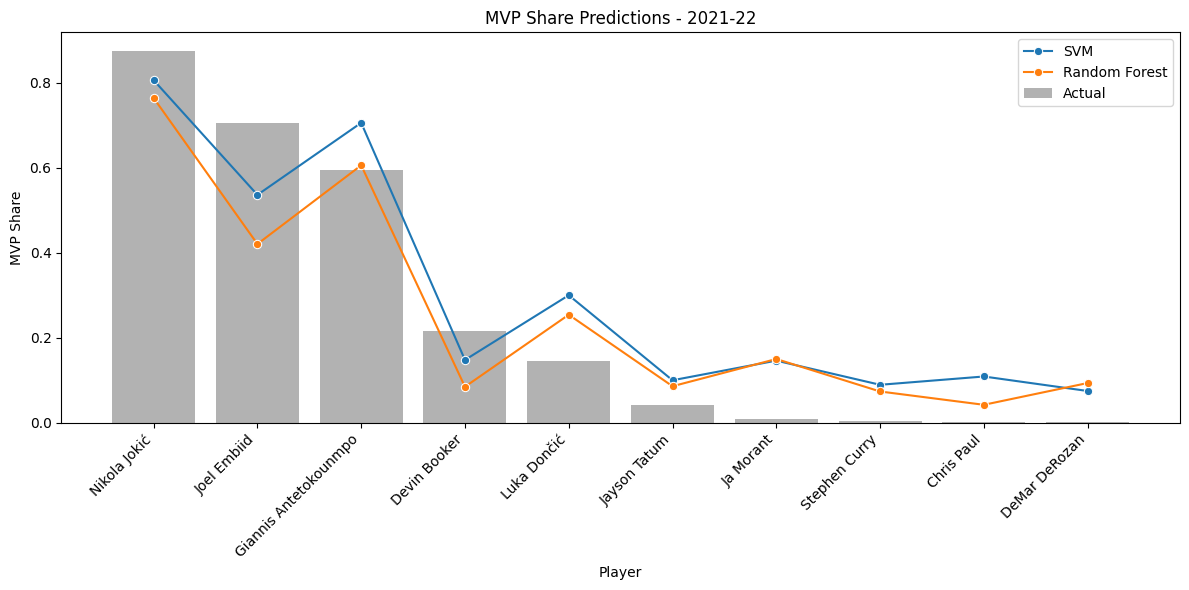

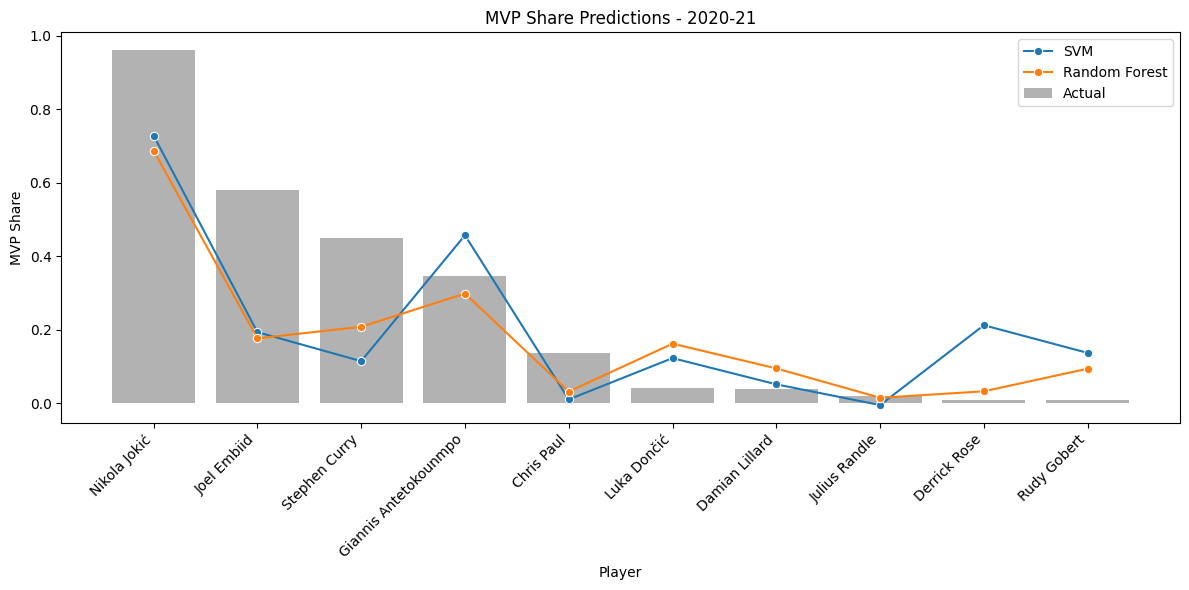

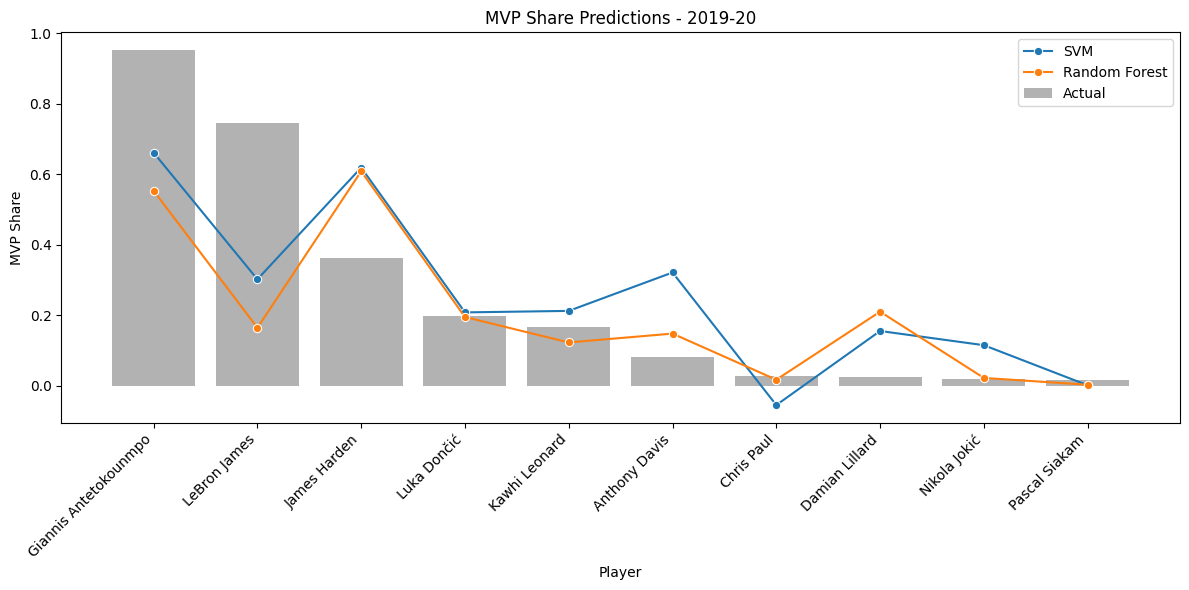

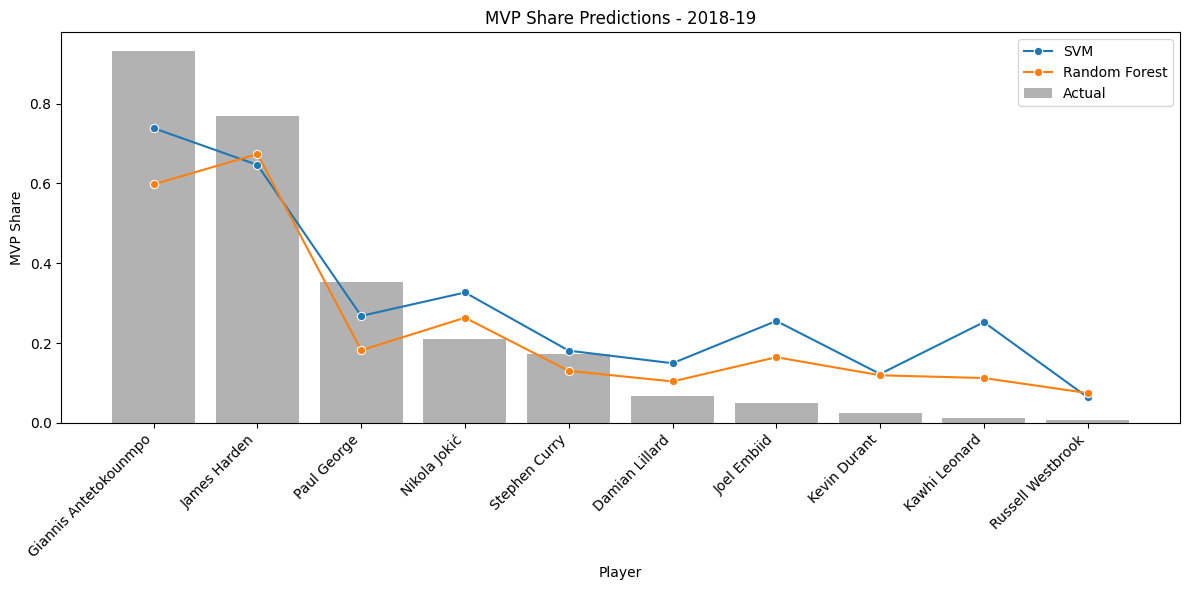

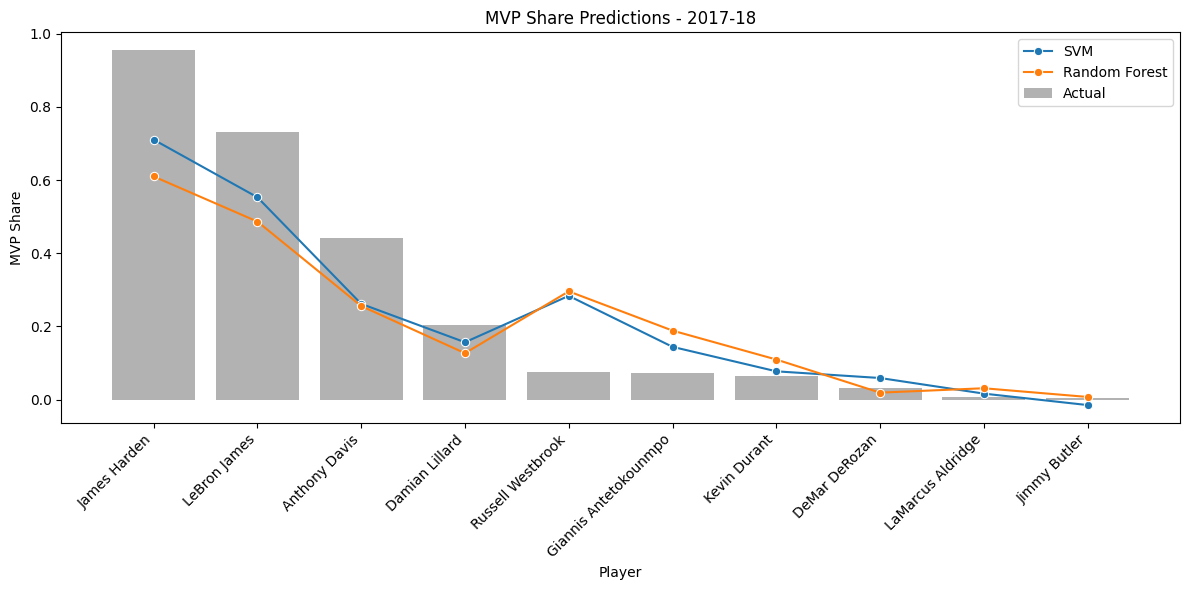

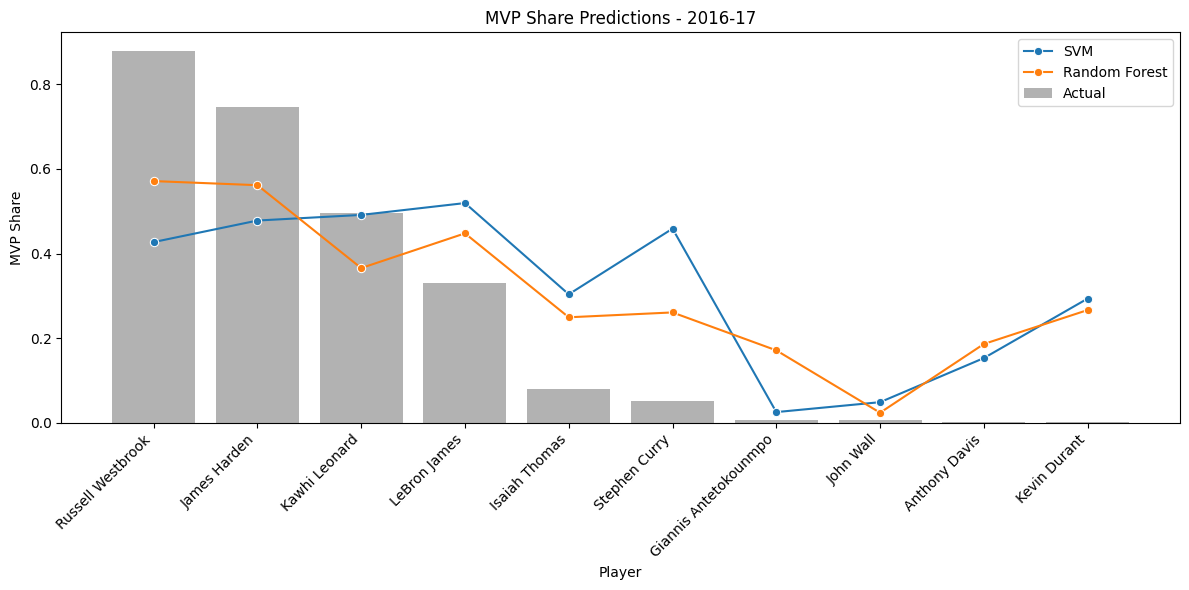

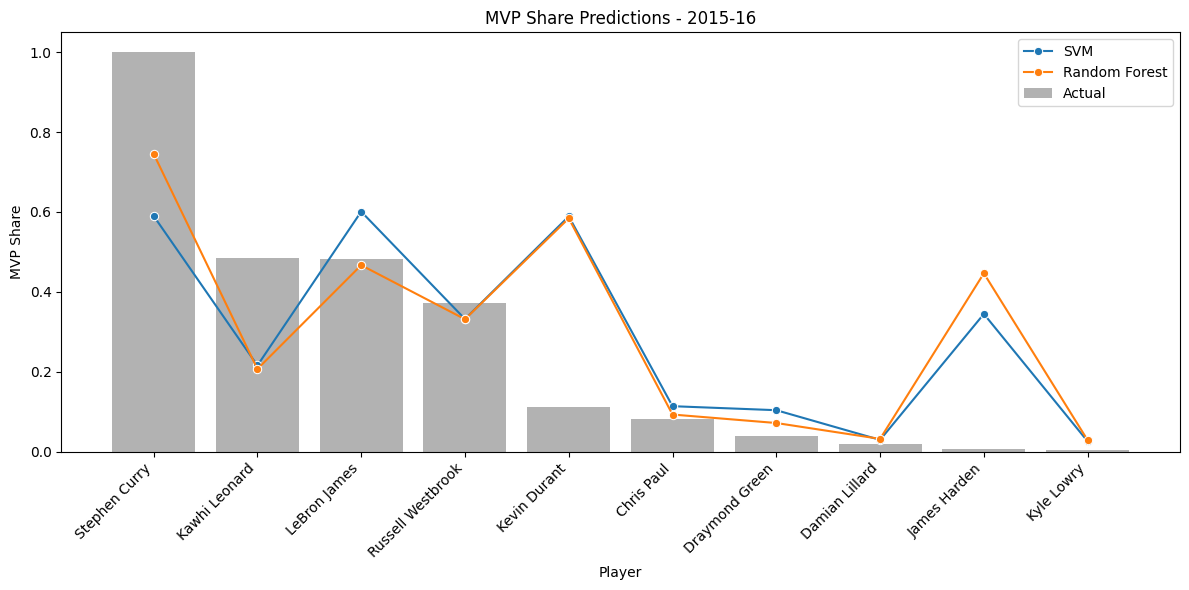

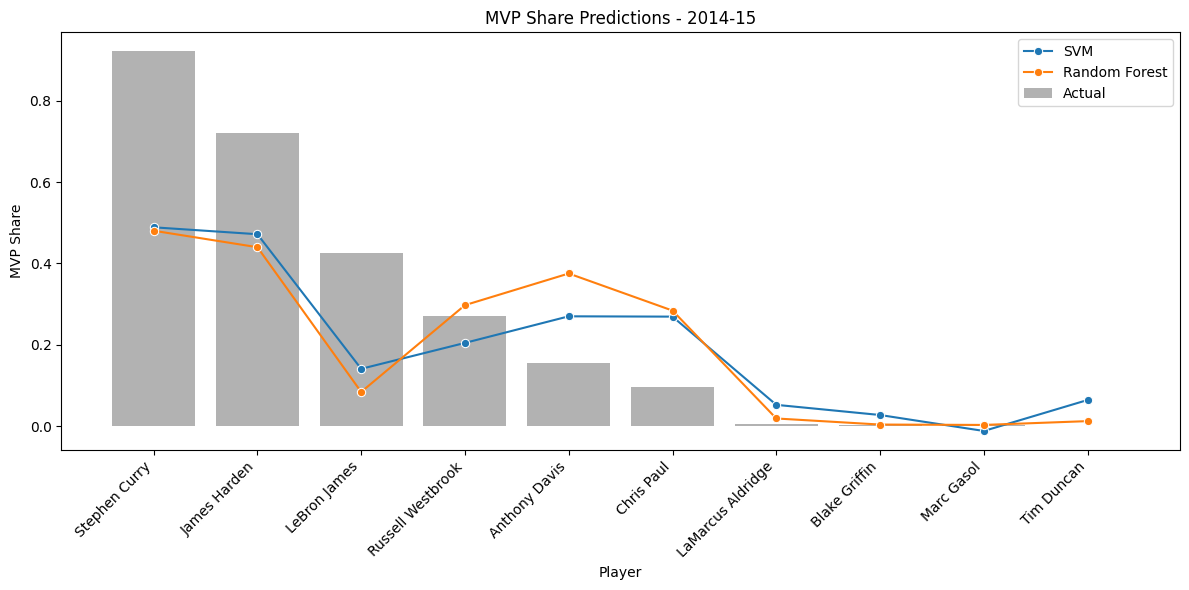

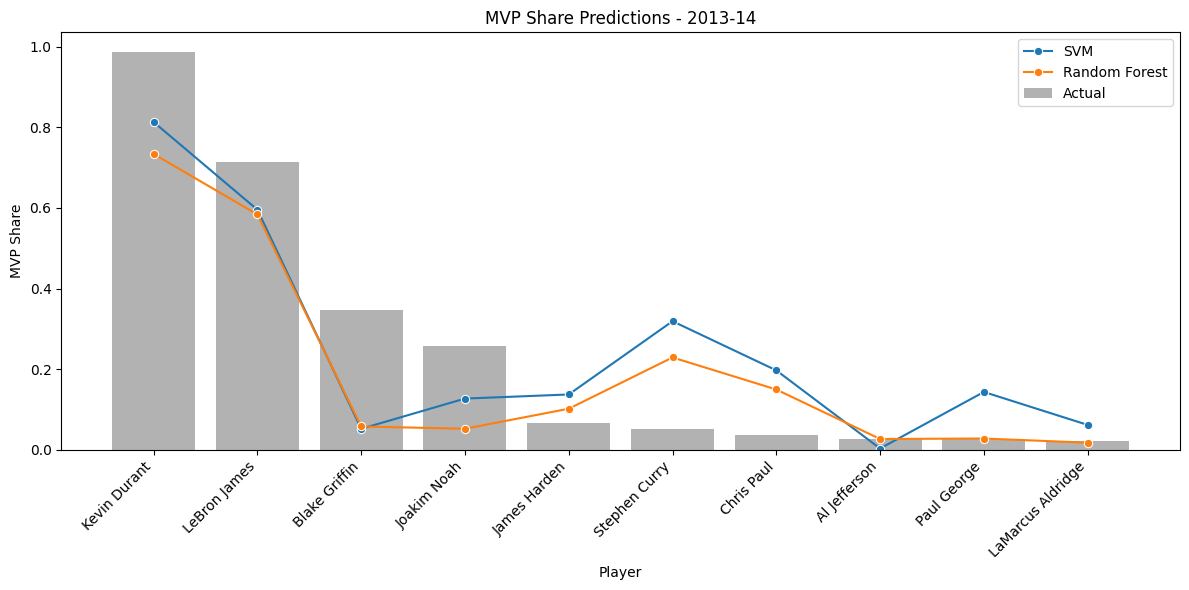

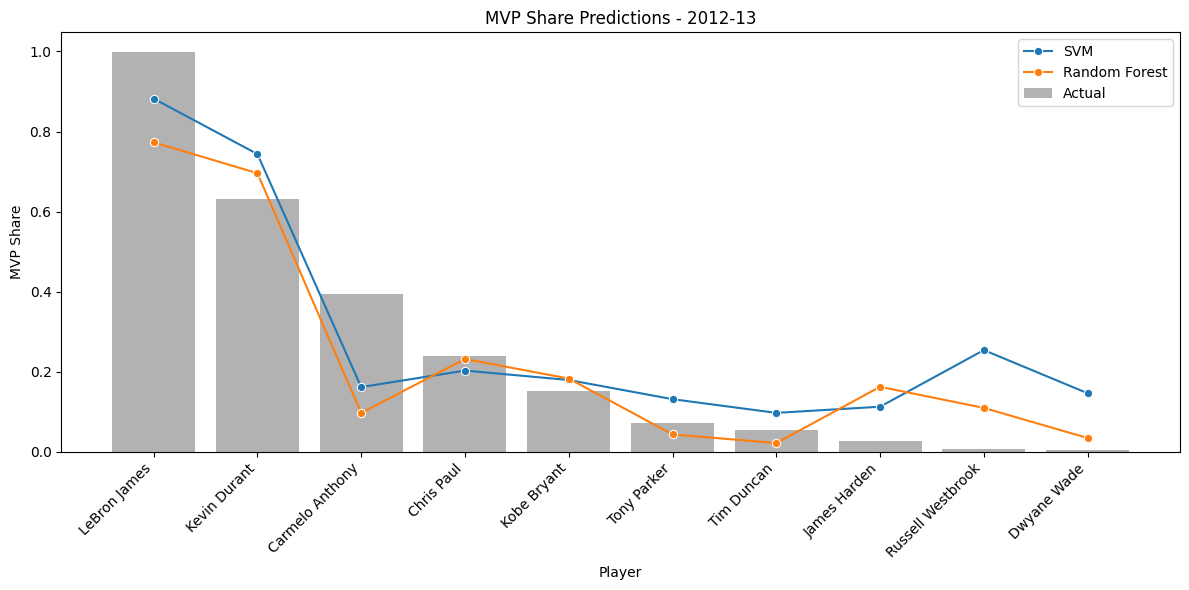

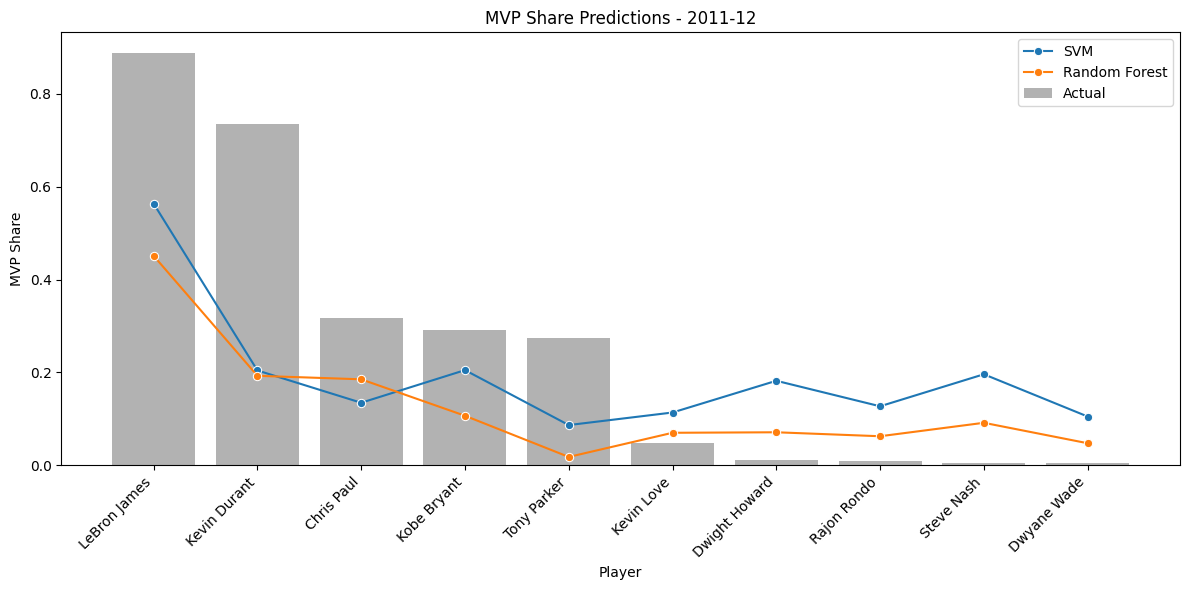

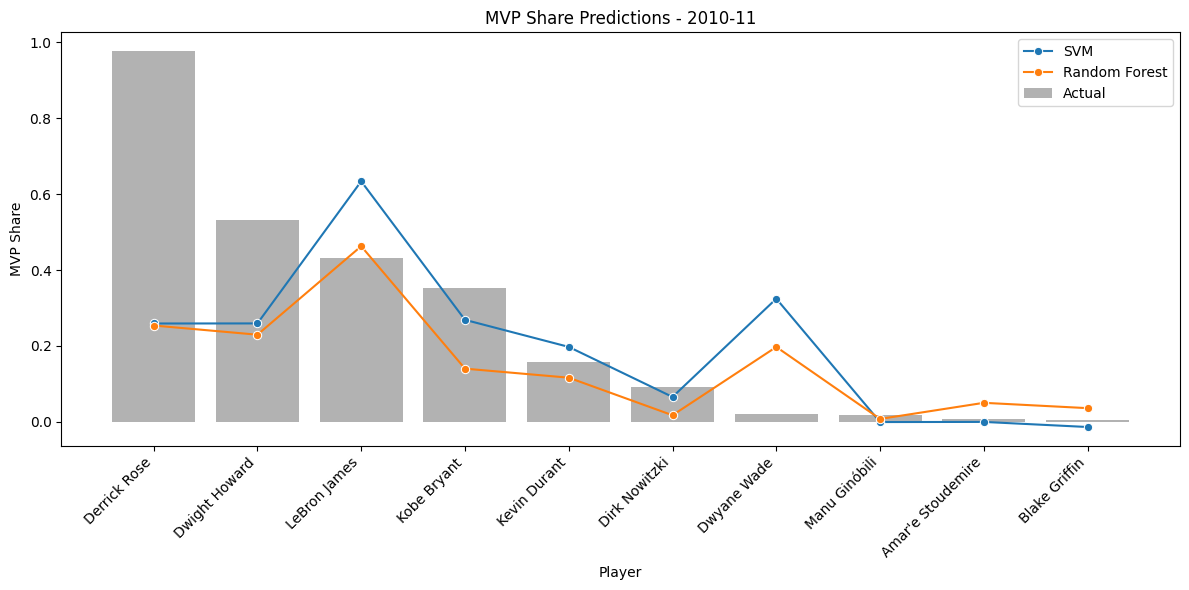

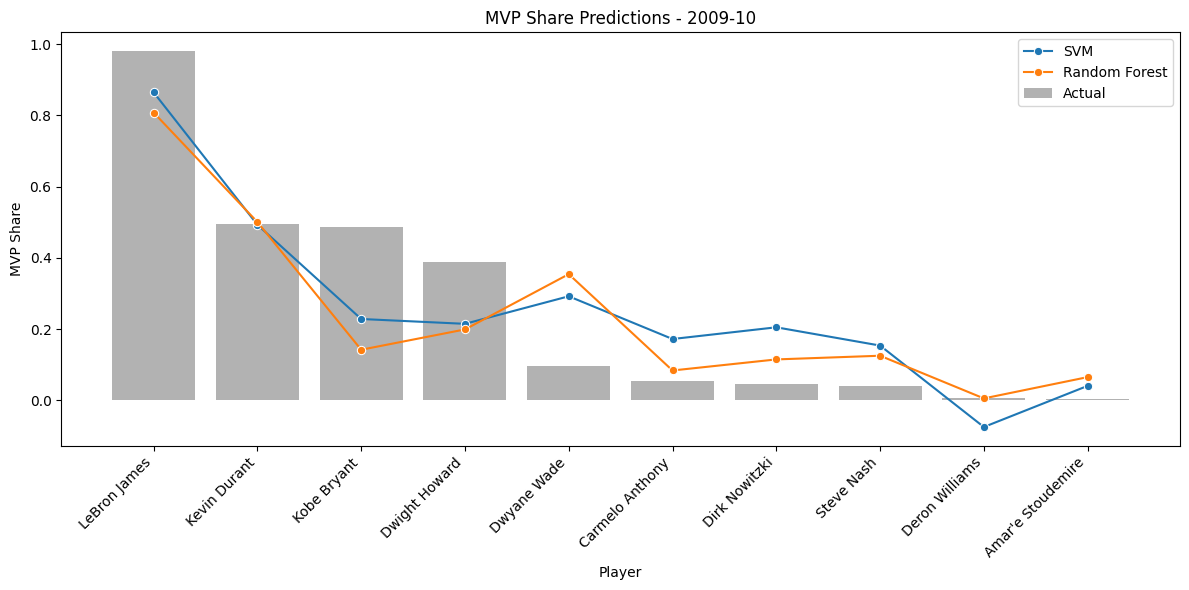

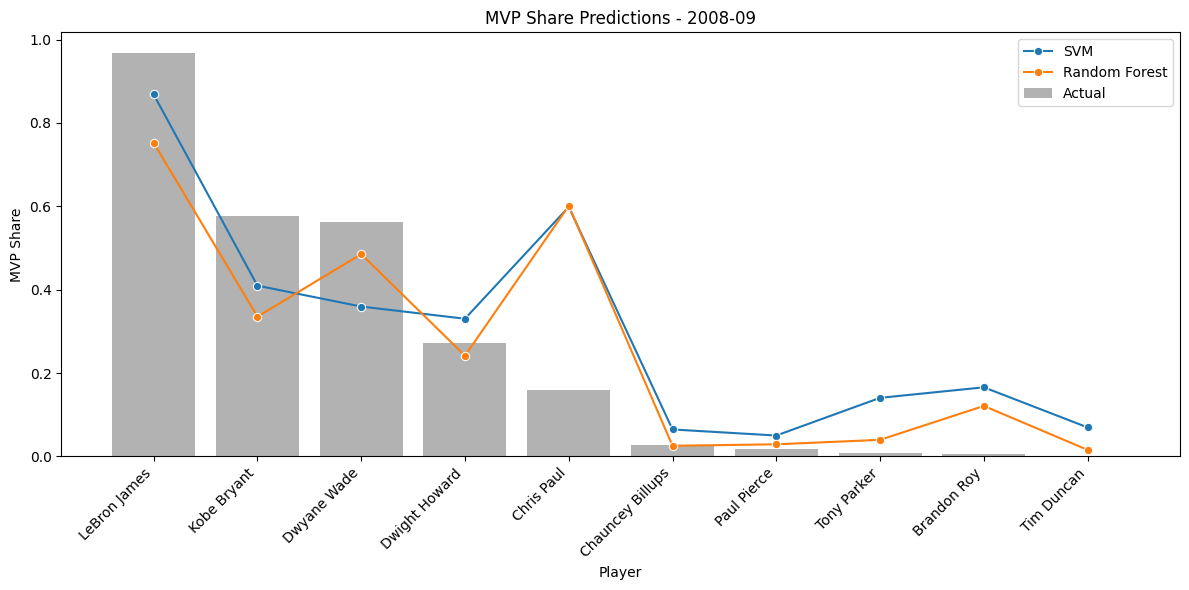

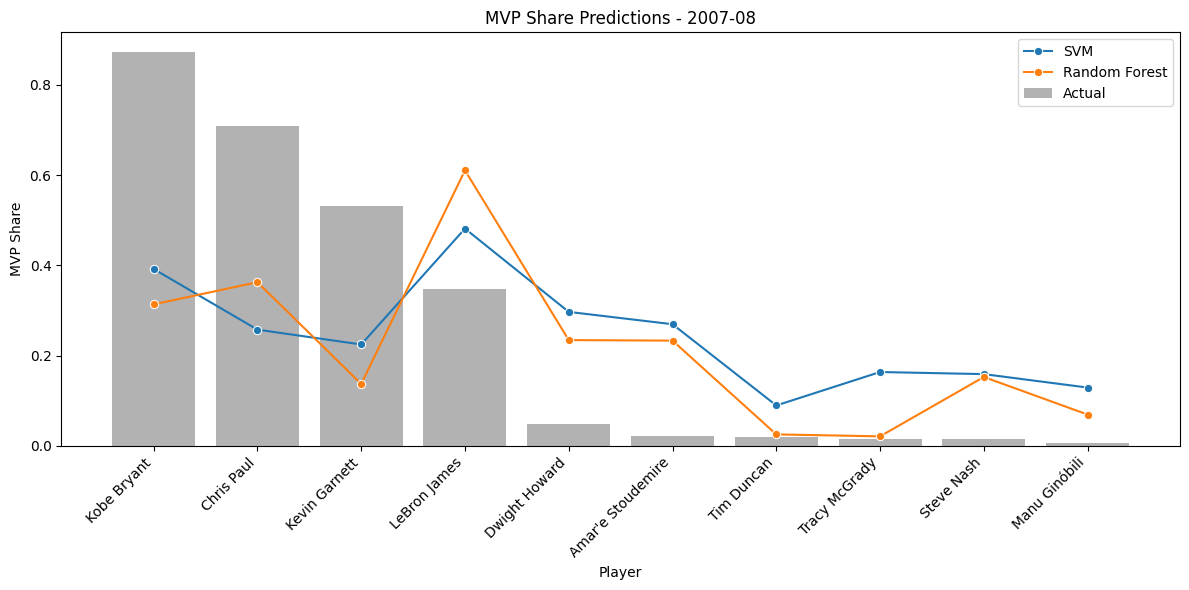

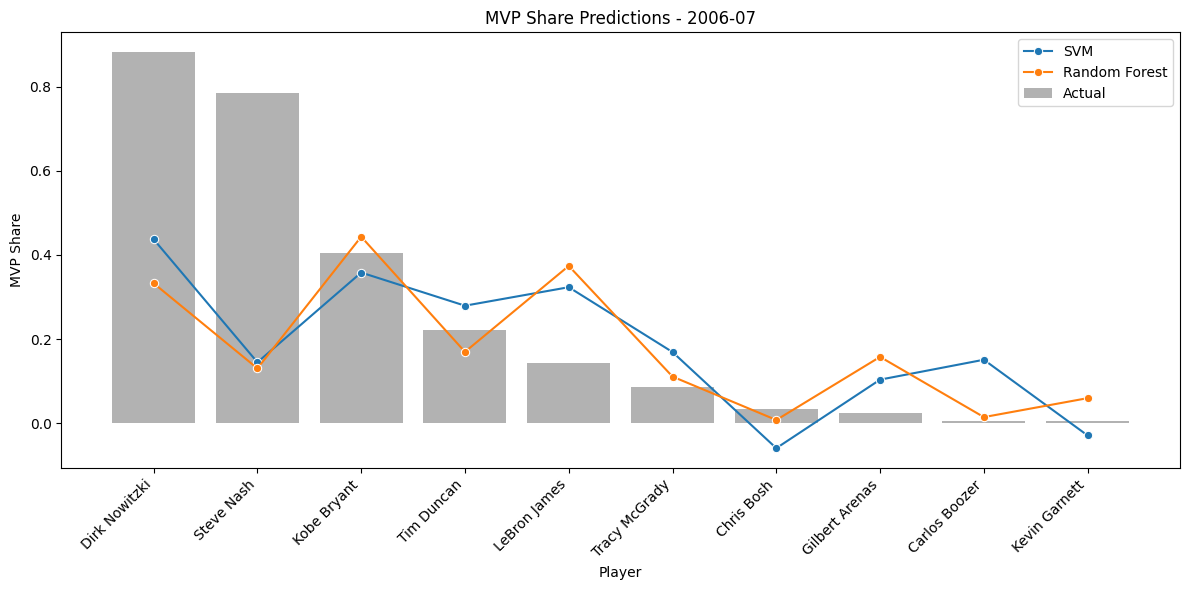

,Player,MVP Rank,MVP Votes Share,MVP Rank SVM,Predicted MVP Share SVM,MVP Rank Random Forest,Predicted MVP Share Random Forest
0,Bam Adebayo,0.0,0.0,14,0.049346,19,0.004925
3,Jaylen Brown,0.0,0.0,22,-0.045053,21,0.003000
5,John Collins,0.0,0.0,16,0.031498,24,0.001045
4,Jimmy Butler,0.0,0.0,15,0.043517,17,0.012935
15,Zach LaVine,0.0,0.0,23,-0.047839,18,0.011950
16,Khris Middleton,0.0,0.0,24,-0.052583,25,0.000705
12,Jrue Holiday,0.0,0.0,20,-0.017388,22,0.002945
11,Darius Garland,0.0,0.0,19,-0.014216,16,0.018555
17,Donovan Mitchell,0.0,0.0,17,0.015566,14,0.031865
24,Trae Young,0.0,0.0,11,0.097535,7,0.154520


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the models you want to visualize
available_models = ['SVM', 'Random Forest']  # Do not include Elastic Net if skipped

# Plot predictions for each season (Top 10 players)
seasons_to_plot = final_results['Season'].unique()

for season in seasons_to_plot:
    df = final_results[final_results['Season'] == season].copy()
    df = df.sort_values('MVP Votes Share', ascending=False).head(10)

    plt.figure(figsize=(12, 6))

    # Bar plot: actual MVP share
    sns.barplot(x='Player', y='MVP Votes Share', data=df, color='gray', label='Actual', alpha=0.6)

    # Overlay: model predictions
    for model in available_models:
        pred_col = f'Predicted MVP Share {model}'
        if pred_col in df.columns:
            sns.lineplot(x='Player', y=pred_col, data=df, marker='o', label=model)

    plt.title(f'MVP Share Predictions - {season}')
    plt.ylabel('MVP Share')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Show table for a specific season (Top 10 players)
season = '2021-22'  # Change as needed
df = final_results[final_results['Season'] == season].copy()

# Ensure MVP Rank is numeric (convert if necessary)
df['MVP Rank'] = pd.to_numeric(df['MVP Rank'], errors='coerce')

# Start with actual columns
cols = ['Player', 'MVP Rank', 'MVP Votes Share']

# Add only available model columns
for model in available_models:
    rank_col = f'MVP Rank {model}'
    share_col = f'Predicted MVP Share {model}'
    if rank_col in df.columns and share_col in df.columns:
        cols.append(rank_col)
        cols.append(share_col)

# Display top 10 players based on real MVP rank
df_display = df[cols].sort_values('MVP Rank').head(10)
display(df_display)


In [ ]:
final_results, metricas = temporadas_antigas(data, seasons, modelos, 16)
final_metricas = media_metricas(metricas)
final_metricas

,Modelo,RMSE,R²
0,KNN,0.144,0.591
1,SVM,0.136,0.642
2,Random Forest,0.131,0.670
3,AdaBoost,0.137,0.638
4,Gradient Boosting,0.127,0.684
5,LGBM,0.128,0.681
6,XGBoost,0.128,0.682


In [ ]:
rank_final = create_rank(final_results, 1)
rank_final

,MVP Rank Real,MVP Share Real,MVP Rank KNN,MVP Share KNN,MVP Rank SVM,MVP Share SVM,MVP Rank Random Forest,MVP Share Random Forest,MVP Rank AdaBoost,MVP Share AdaBoost,MVP Rank Gradient Boosting,MVP Share Gradient Boosting,MVP Rank LGBM,MVP Share LGBM,MVP Rank XGBoost,MVP Share XGBoost,Season
0,Nikola Jokić,0.875,Nikola Jokić,0.700,Nikola Jokić,0.806,Nikola Jokić,0.772,Nikola Jokić,0.626,Nikola Jokić,0.615,Giannis Antetokounmpo,0.641,Giannis Antetokounmpo,0.601,2021-22
1,Nikola Jokić,0.961,Nikola Jokić,0.687,Nikola Jokić,0.728,Nikola Jokić,0.704,Nikola Jokić,0.663,Nikola Jokić,0.584,Nikola Jokić,0.584,Nikola Jokić,0.584,2020-21
2,Giannis Antetokounmpo,0.952,Giannis Antetokounmpo,0.581,Giannis Antetokounmpo,0.661,James Harden,0.548,James Harden,0.498,Giannis Antetokounmpo,0.746,Giannis Antetokounmpo,0.724,Giannis Antetokounmpo,0.750,2019-20
3,Giannis Antetokounmpo,0.932,James Harden,0.712,Giannis Antetokounmpo,0.738,James Harden,0.685,James Harden,0.615,Giannis Antetokounmpo,0.766,Giannis Antetokounmpo,0.760,Giannis Antetokounmpo,0.778,2018-19
4,James Harden,0.955,LeBron James,0.591,James Harden,0.710,James Harden,0.617,James Harden,0.831,James Harden,0.948,James Harden,0.989,James Harden,0.976,2017-18
5,Russell Westbrook,0.879,LeBron James,0.570,LeBron James,0.519,Russell Westbrook,0.561,Kawhi Leonard,0.623,Russell Westbrook,0.602,Kawhi Leonard,0.592,Kawhi Leonard,0.592,2016-17
6,Stephen Curry,1.000,Stephen Curry,0.528,LeBron James,0.601,Stephen Curry,0.752,Stephen Curry,0.808,Stephen Curry,0.990,Stephen Curry,0.988,Stephen Curry,0.986,2015-16
7,Stephen Curry,0.922,James Harden,0.479,Stephen Curry,0.489,James Harden,0.473,Stephen Curry,0.604,Stephen Curry,0.629,Stephen Curry,0.590,Stephen Curry,0.618,2014-15
8,Kevin Durant,0.986,Kevin Durant,0.661,Kevin Durant,0.813,Kevin Durant,0.734,Kevin Durant,0.775,Kevin Durant,0.773,Kevin Durant,0.773,Kevin Durant,0.773,2013-14
9,LeBron James,0.998,Kevin Durant,0.711,LeBron James,0.882,LeBron James,0.795,LeBron James,0.854,Kevin Durant,0.901,Kevin Durant,0.901,Kevin Durant,0.901,2012-13


## Variable Analysis - SHAP

In [ ]:
data_test = data[data['Season']=='2021-22']
X_test = data_test.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)

scaler = StandardScaler()

scaled_X_test = scaler.fit_transform(X_test)

In [ ]:
gb_model = pickle.load(open(path_data+sep+'Modelos'+sep+'GradientBoosting.dat','rb'))
rf_model = pickle.load(open(path_data+sep+'Modelos'+sep+'RandomForest.dat','rb'))
en_model = pickle.load(open(path_data+sep+'Modelos'+sep+'ElasticNet.dat','rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/NBA-Modelo-MVP/Modelo MVP/Modelos/GradientBoosting.dat'

In [ ]:
print(type(scaled_X_test))
print(scaled_X_test)

In [ ]:
player_dataf = player_dataf.astype(float)
gb_explainer = shap.Explainer(gb_model.predict, player_dataf)
gb_shap_values = gb_explainer(player_dataf)

rf_explainer = shap.Explainer(rf_model.predict, scaled_X_test)
rf_shap_values = rf_explainer(scaled_X_test)

en_explainer = shap.Explainer(en_model.predict, scaled_X_test)
en_shap_values = en_explainer(scaled_X_test)

In [ ]:
shap.summary_plot(en_shap_values, X_test, plot_type='violin') # Top 20 variables

In [ ]:
shap.summary_plot(rf_shap_values, X_test, plot_type='violin', max_display=len(X_test.columns)) # All variables

In [ ]:
shap.summary_plot(gb_shap_values, X_test, plot_type='violin', max_display=len(X_test.columns)) # All variables